In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from datetime import datetime , timedelta
import requests
from scipy.signal import find_peaks
import statsmodels.api as sm
warnings.filterwarnings('ignore')

### Regime Classification

In [2]:
class LengthMismatchException(Exception):
    pass

class NonMutualExclusive(Exception):
    pass

def unequal_compare(arr1, arr2):
    arr2 = np.unique(arr2)
    df1 = pd.DataFrame(data=[1]*len(arr1), columns=['df1'] ,index=arr1)
    df1['idx'] = range(df1.shape[0])
    merged_df = df1.join(pd.DataFrame(data= [1]*len(arr2), columns=['df2'] , index=arr2))
    df3 = pd.DataFrame(data={'df3':np.invert(merged_df.isnull().any(axis=1)), 'idx':merged_df['idx'] }).sort_values(by='idx')
    return df3['df3'].to_numpy()

class RegimeDetection():
    
    def __init__(self, regime_data, *args, **kwargs):
        if len(args) != len(kwargs):
            print(f'{len(args)} not equal to {len(kwargs)}')
            raise LengthMismatchException
        if len(regime_data.columns) != 1:
            raise LengthMismatchException
        df = regime_data.copy()
        df.columns = ['data']
        sample_length = len(df)
        i = 0
        for feature, func in kwargs.items():
            new_feaure = (func(df['data'], **args[i])).tolist()
            df[f'{feature}'] = [np.nan] * (sample_length - len(new_feaure)) + new_feaure
            i +=1
        df.dropna(inplace=True)
        self.database = df
        self.index = df.index
        self.features = df.columns
        self.custom = False

    def custom_regimes(self, n_regimes, where):
        if len(where) != n_regimes -1 :
                raise NonMutualExclusive
        if len(where) > 1:
            for i in range(n_regimes-2):
                for j in range(i+1,n_regimes-1):
                    if len(self.database.loc[ (where[i]) & (where[j])]) != 0 :
                        raise NonMutualExclusive
        labels = np.array([n_regimes-1]*len(self.index))
        where = list(map(pd.Series.to_numpy, where))
        for i in range(n_regimes-1):
            labels[where[i]] = i
        self.labels = labels
        self.n_regimes = n_regimes
        self.regimes = {f'regime{i}': self.index[self.labels == i] for i in range(self.n_regimes)}
        self.custom = True
    
    def backtest(self, price_data , print_ = True, portfolio = True ):
        price_data = price_data.copy()
        price_data.index = pd.to_datetime(price_data.index)  
        price_data.interpolate(method='linear', limit_direction='forward', axis=0)
        price_data.dropna(inplace = True) 
        price_index = price_data.index
        price_data = (price_data / price_data.shift(1) - 1)
        full_sample_length = len(price_data)
        if portfolio:
            n_methods = len(self.methods)
            self.price_data = price_data.join(pd.DataFrame({f'method {self.methods[i]}': (self.weights[i] * price_data.iloc[full_sample_length - self.weights_length: , :].to_numpy()).sum(axis=1)  for i in range(n_methods)}, index= price_index[ len(price_index) - self.weights_length :])  )
        else:
            self.price_data = price_data
        self.merged_data =  self.price_data.join( pd.DataFrame( self.labels[1:], columns = ['label'], index = self.index[1:]) ).dropna() 
        equity_by_regime = {f'regime{i}' : np.insert( ((self.merged_data.loc[self.merged_data.label == i].iloc[:,:-1] + 1).cumprod(axis = 0).to_numpy().T), 0, 1, axis = 1)  
                            for i in range(self.n_regimes)} 
        returns_by_regime = {f'regime{i}': equity_by_regime[f'regime{i}'][:,1:]/equity_by_regime[f'regime{i}'][:,:-1] -1 for i in range(self.n_regimes)}
        if print_ == True:
            fig , ax  = plt.subplots( self.n_regimes ,1 , figsize = (20,10))
            plt.style.use('_mpl-gallery-nogrid')
            for i in range(self.n_regimes):
                ax[i].set_title(f'regime{i}', fontsize=16)
                for j in range(self.price_data.shape[1]):
                    ax[i].plot(equity_by_regime[f'regime{i}'][j], label = self.price_data.columns[j] )
                    ax[i].legend()
            fig.tight_layout(pad=0)
        
        print('all data points:',self.merged_data['label'].value_counts(), sep='\n')
        metrics = ['average return', 'vol', 'sharpe ratio']
        performance =[]
        for i in range(self.n_regimes):
            for j in range(self.price_data.shape[1]):
                returns = returns_by_regime[f'regime{i}'][j]
                performance.append([ returns.mean()*252 , returns.std()*252**0.5 , returns.mean()/returns.std() * 252**0.5 ])
        performance = np.array(performance).reshape( self.n_regimes, (self.price_data.shape[1])* len(metrics))
        result = pd.DataFrame(data = performance, columns = pd.MultiIndex.from_product( [ self.price_data.columns, metrics], names = ['allocation method', 'metrics']) , index = [f'regime {i}' for i in range(self.n_regimes)])
        result.index.name = 'regimes'
        if print_ == True:
            display(result)
        return returns_by_regime

## Data Extraction

In [3]:
data_5assets = pd.read_csv('data_5assets.csv', index_col=0, parse_dates=True)

In [4]:
gdp = pd.read_csv('gdp.csv', index_col=0, parse_dates=True)

In [5]:
inflation = pd.read_csv('inflation.csv', index_col=0, parse_dates=True)

## All weather portfolio construction

#### functions to define rising and falling regimes

In [7]:
def peak_trough(data, **kwargs):
    rst = np.array([np.nan]* len(data))
    peaks, _ = find_peaks(data, **kwargs)
    troughs, _ = find_peaks(-data, **kwargs)
    rst[peaks] = 1
    rst[troughs] = -1
    rst = pd.DataFrame(rst).fillna(method = 'bfill')
    rst = rst.fillna(-rst.iloc[max(peaks[-1], troughs[-1]),0])
    return rst.iloc[:,0]

def rate_of_change(data, days):
    return pd.Series(data).pct_change(freq=f'{days}d')

### functions for portfolio result evaluation

In [8]:
def return_over_maxdrawdown(arr):
    equity = (arr+1).cumprod()
    maxdd = (equity/pd.Series(equity).cummax()-1).min()  
    returns = arr.mean()
    return -returns/maxdd

def maxdd(arr):
    equity = (arr+1).cumprod()
    maxdd = (equity/pd.Series(equity).cummax()-1).min()
    return -maxdd

def plot_errors(alp, weights, labels):
    fig, ax = plt.subplots(1, 1, figsize = (10,7))
    errors = [alp.Objective_metric(w) for w in weights]
    ax.set_title('std of maxdd between regimes', fontsize=16)
    ax.bar(labels, errors)


In [9]:

def product_combinations(lis):
    if len(lis) <2:
        return None
    if len(lis) == 2:
        return [[i]+j if type(j) == list else [i]+[j] for j in lis[1] for i in lis[0]]
    else:
        return product_combinations([lis[0], product_combinations(lis[1:])])

def common_dates(lis, p):
    if len(lis) < 2:
        return None
    if len(lis) == 2 and p == 0:
        return unequal_compare(lis[0], lis[1])
    elif len(lis) == 2:
        return np.array(lis[0])[unequal_compare(lis[0], lis[1])]
    else:
        return common_dates([lis[0], common_dates(lis[1:] , p+1)] ,p)   
    
def plot_graph(seriess, idxs, labels):
    n = len(seriess)
    fig, ax= plt.subplots(1,1 ,figsize=(20,10))
    for i in range(n):
        ax.plot( idxs[i], seriess[i] , label = f'{labels[i]}')
    ax.legend()
    return ax

def substitute_str(string):
    return string.replace('data0', 'inflation').replace('data1', 'GDP').replace('regime0', 'rising').replace('regime1', 'falling')



class All_Weather_Portfolio:
    def __init__(self,stock_data, variable_to_classify, arguments,*args ):
        self.n_data = len(args)
        self.n_regimes = 2
        self.n_assets = stock_data.shape[1]
        self.regime_data = {}
        self.returns = {}
        self.regimes = {}
        self.stock_data = stock_data
        self.max_data_length = 'data0_regime0'
        for i,regime_data in enumerate(args):
            detecter = RegimeDetection(regime_data , arguments[i], peak = peak_trough )
            detecter.custom_regimes(self.n_regimes ,where= [ detecter.database[variable_to_classify[i]] >0])
            self.regime_data[f'data{i}'] = detecter.database
            self.returns[f'data{i}'] = detecter.backtest(stock_data, print_= False, portfolio=False)
            for j in range(detecter.n_regimes):
                self.regimes[f'data{i}_regime{j}'] = detecter.merged_data.index[detecter.merged_data['label'] == j]
                if len(self.regimes[f'data{i}_regime{j}']) > len(self.regimes[self.max_data_length]):
                    self.max_data_length = f'data{i}_regime{j}'

    def regime_combinations(self):
        self.n_combin = None
        self.all_returns = {}
        self.all_regimes = {}
        self.regime_length = {}
        combin =  [product_combinations([ [f'data{i}_'], [f'regime{j}' for j in range(self.n_regimes)]]) for i  in range(self.n_data) ] 
        for i in range(len(combin)):
            for j in range(len(combin[i])):
                combin[i][j] = ''.join(combin[i][j])
        combin =  product_combinations(combin)
        print(f'combinations:\n{combin}')
        self.n_combin = len(combin)
        print('data points by combin:')
        for i in combin:
            idxs=[]
            for j in i:
                lis = i.copy()
                lis.remove(j)
                idxs.append(common_dates([self.regimes[j]]+[ self.regimes[k] for k in lis ] , 0 ))
            self.all_regimes[f"{'-'.join(i)}"] = self.regimes[f'{i[0]}'][idxs[0]]
            self.all_returns[f"{'-'.join(i)}"] = self.returns[f"{i[0].split('_')[0]}"][f"{i[0].split('_')[1]}"][:, idxs[0]]
            self.regime_length[f"{'-'.join(i)}"] = len(self.regimes[f'{i[0]}'][idxs[0]])
            print(f"{'-'.join(i)}: {len(self.regimes[f'{i[0]}'][idxs[0]])}")
            
    def Objective_metric(self ,weight):
        self.metric_byregime_error = {}
        self.optimise_invalid_datas = []
        self.error = 0
        for regime, returns in self.all_returns.items():
            if returns.shape[1] < 10:
                self.std_invalid_datas.append(regime)
                print(f'{regime} may not have enough data points')
                continue
            portr = returns.T @ weight
            self.metric_byregime_error[f"{regime}"] = maxdd(portr)
        if len(self.metric_byregime_error) >=2:
            self.error = np.std(list(self.metric_byregime_error.values()))
        self.weight = weight
        return self.error

    def Optimize(self, objective_function, *args):
        objective_function = objective_function
        cons = ({ 'type' : 'ineq' , 'fun' : lambda x : x-0.001 }, { 'type' : 'ineq' , 'fun' : lambda x : 0.9-x }, { 'type' : 'eq' , 'fun' : lambda x : np.sum(x) -1 })
        initial_guess = np.repeat(1/self.n_assets, self.n_assets)
        result = minimize(objective_function , initial_guess , args , constraints = cons , method = 'SLSQP')
        return result

    def plot_regimes(self, stock_data, weights ,labels ,*args):
        stock_data.dropna(inplace=True)
        n_weights = len(weights)
        idx = stock_data.index
        benchmark = [benchmark.loc[benchmark.index[unequal_compare(benchmark.index, idx)]] for benchmark in args]
        benchmark_idx = [i.index for i in benchmark]
        performance = [((stock_data/stock_data.shift(1)-1).fillna(0).to_numpy()@w +1).cumprod() for w in weights] + [((b/b.shift(1)-1).fillna(0).to_numpy() +1).cumprod() for b in benchmark]
        plot = plot_graph(performance, [idx]*n_weights + benchmark_idx , labels)
        max_ = 0
        for p in performance:
            if p.max() > max_:
                max_ = p.max()
        for regime, dates in self.all_regimes.items():
            plot.fill_between(idx , 0.8, max_, where= unequal_compare(idx, dates), alpha=0.1, label=f'{substitute_str(regime)}')
            plot.legend(loc=0)
 
    def plot_performance_byregime(self, weights, labels, mode=0, legend = True, stats= False):
        rf = -0.000318
        fig, ax = plt.subplots( len(self.all_regimes),1 , figsize = (15,20))
        k = list(self.all_regimes.keys())
        statistics = []
        for i , (regime, returns) in enumerate(self.all_returns.items()):
            #statistics = []
            ax[i].set_title(f'{substitute_str(k[i])}', fontsize=16)
            if mode == 0:
                for j, asset in enumerate(returns):
                    equity = (asset+1).cumprod()
                    ax[i].plot(equity,label=f'{self.stock_data.columns[j]}')
            for p,weight in enumerate(weights):
                if stats:
                    statistics.append([(np.mean(returns.T @ weight)-rf)/np.std(returns.T @ weight),
                                      np.std(returns.T @ weight),
                                      return_over_maxdrawdown(returns.T @ weight),
                                      maxdd(returns.T @ weight)])
                portr = (returns.T@weight+1).cumprod()
                ax[i].plot(portr ,label = f'{labels[p]}')
                ax[i].set_ylabel('equity')
            if legend == True:
                ax[i].legend()
  
        if stats:
            #fig1, ax1 = plt.subplots(4, 1, figsize=(10,5))
            xaxis = np.array([substitute_str(regime) for regime in self.all_returns.keys()]).reshape(-1,1)
            col = ['regime']+labels
            statistics = np.array(statistics)
            measures = ['risk-adjusted return', 'std', 'returns/maxdd', 'maxdd']
            for v in range(statistics.shape[1]):
                df = pd.DataFrame(np.concatenate([xaxis, statistics[:,v].reshape(-1, len(labels))],axis=1), columns=col)
                df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)
                plot = df.plot(x='regime', y=labels, kind='bar', figsize=(10,5), title=f'{measures[v]}')
                plot.tick_params(axis='x',labelrotation=25)

        fig.tight_layout(pad=0)


### Train-test data split

In [10]:
train_data = data_5assets.loc[:'2014-01-01'].dropna()
test_data = data_5assets.loc['2014-01-02':]

In [11]:
ALP = All_Weather_Portfolio(train_data, ['peak', 'peak'], [{'prominence':1},{}], inflation, pd.DataFrame(rate_of_change(gdp.GDP,120), index=gdp.index) )
ALP.regime_combinations()

all data points:
1    2870
0    2629
Name: label, dtype: int64
all data points:
0    2886
1    2613
Name: label, dtype: int64
combinations:
[['data0_regime0', 'data1_regime0'], ['data0_regime1', 'data1_regime0'], ['data0_regime0', 'data1_regime1'], ['data0_regime1', 'data1_regime1']]
data points by combin:
data0_regime0-data1_regime0: 1400
data0_regime1-data1_regime0: 1486
data0_regime0-data1_regime1: 1229
data0_regime1-data1_regime1: 1384


## Performance of assets under different market environment

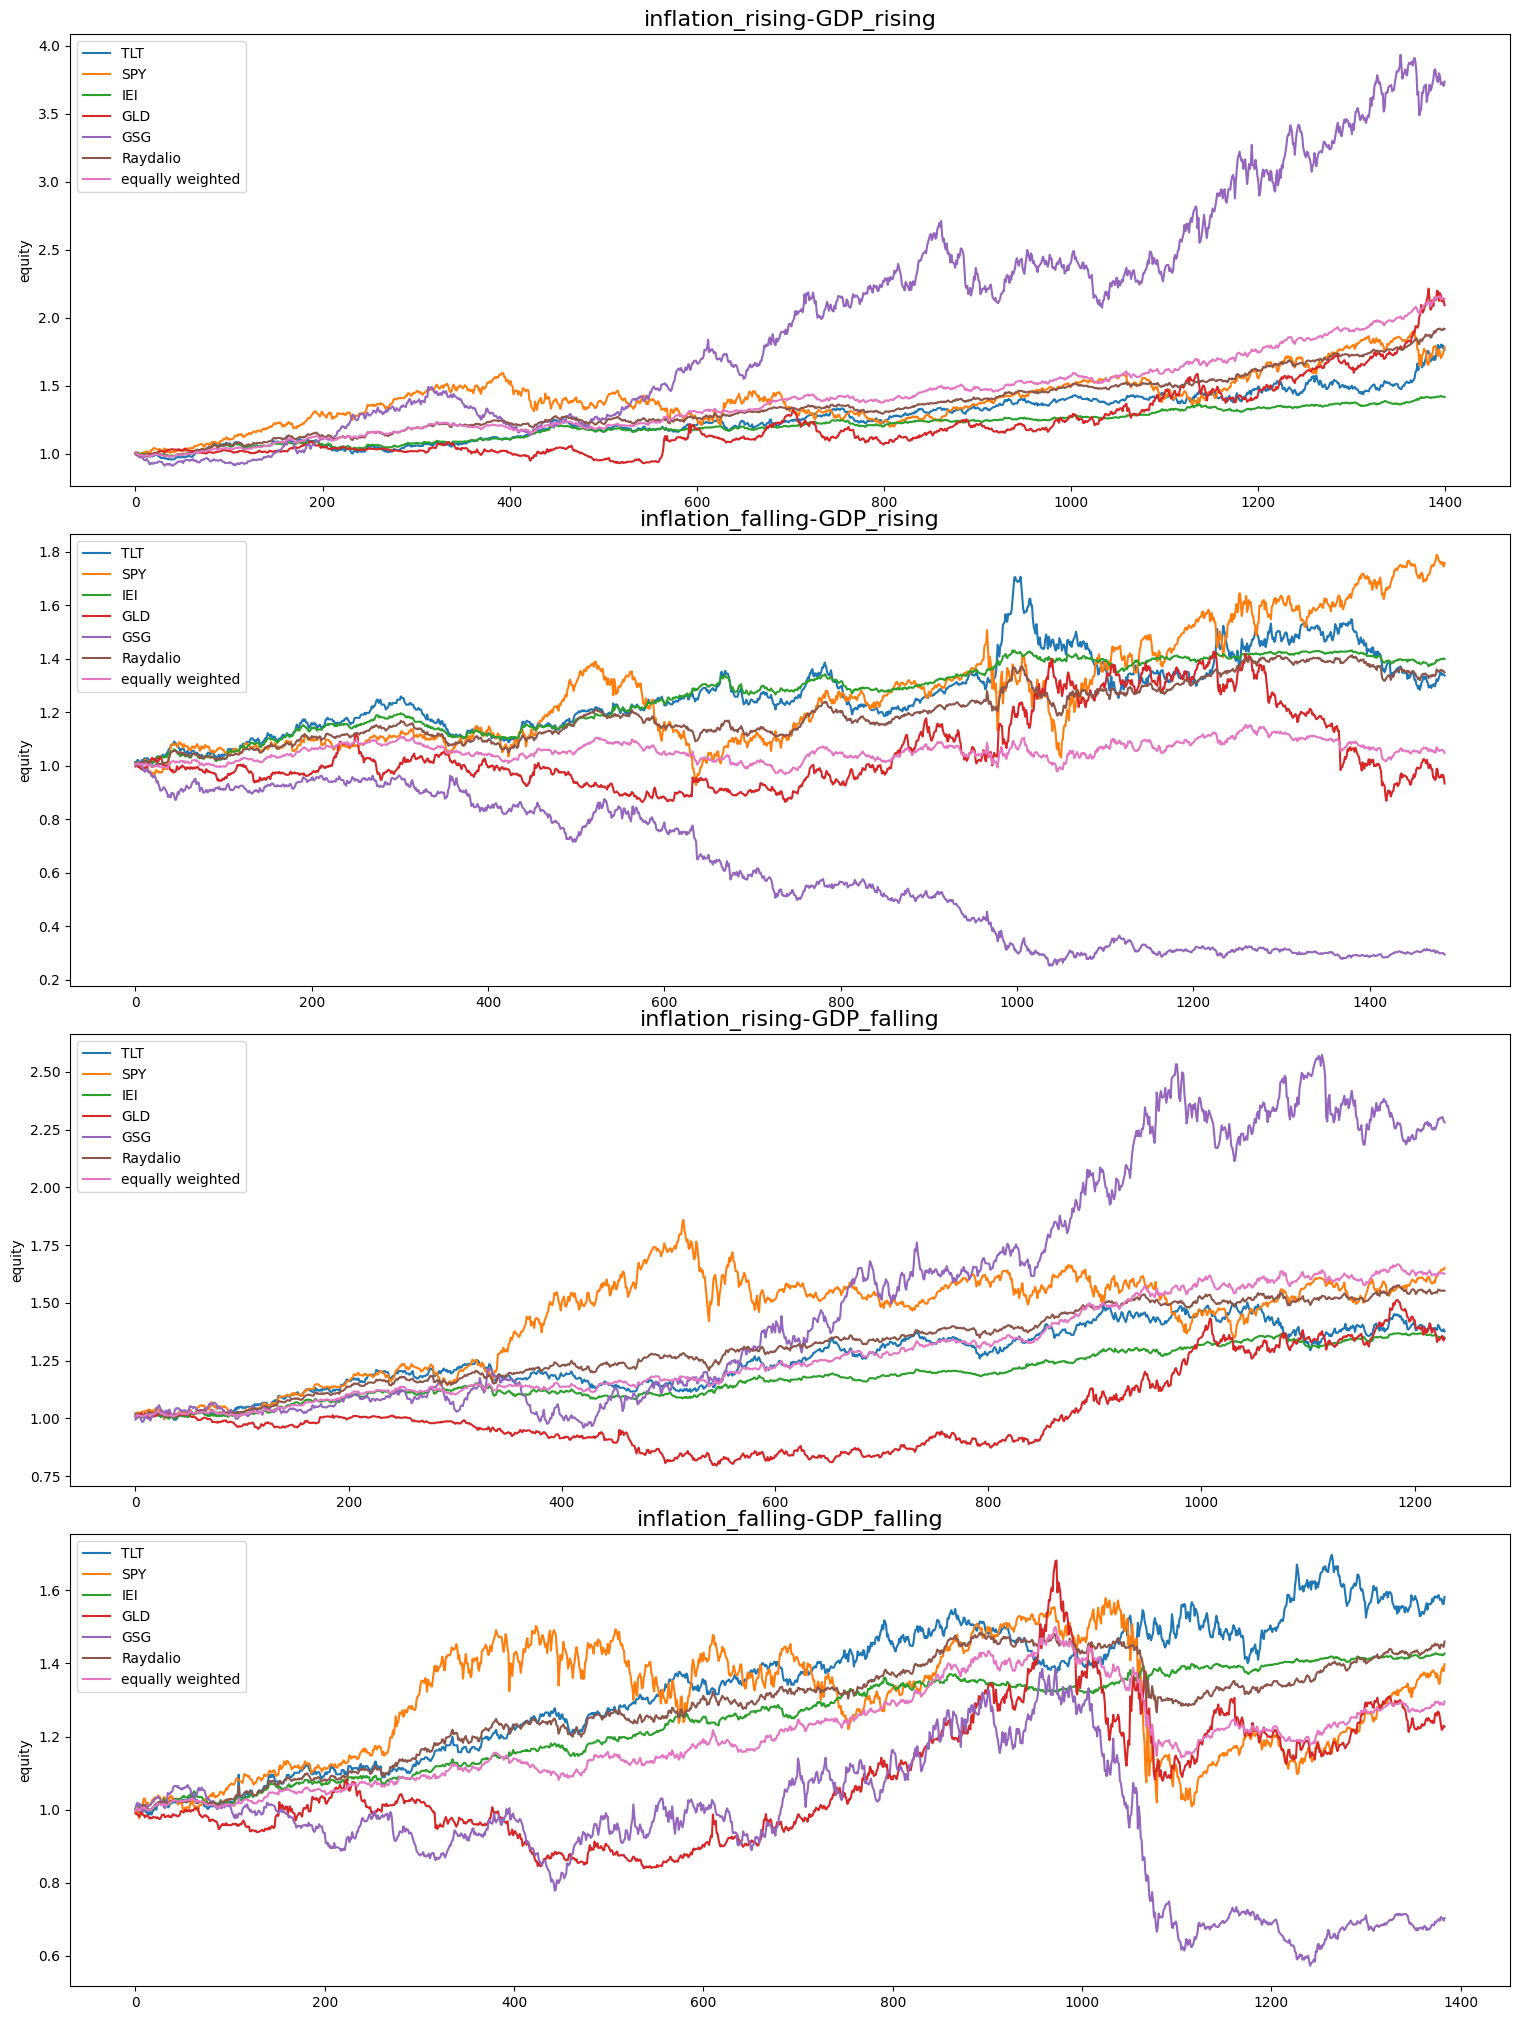

In [12]:
test_set = [[0.4,0.3,0.15,0.075,0.075], np.repeat(1/5,5)]
labels = ['Raydalio', 'equally weighted']
ALP.plot_performance_byregime(test_set , labels, mode=0, stats=False)

## Observations

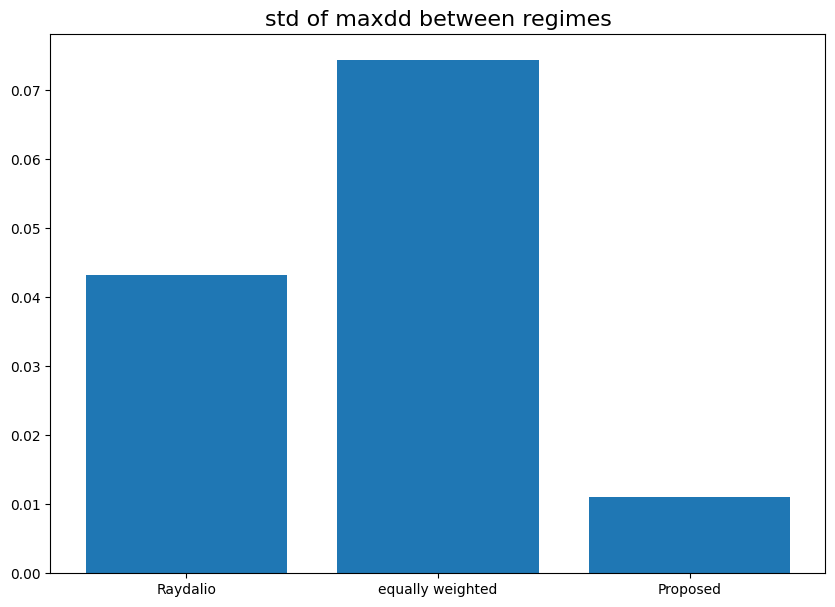

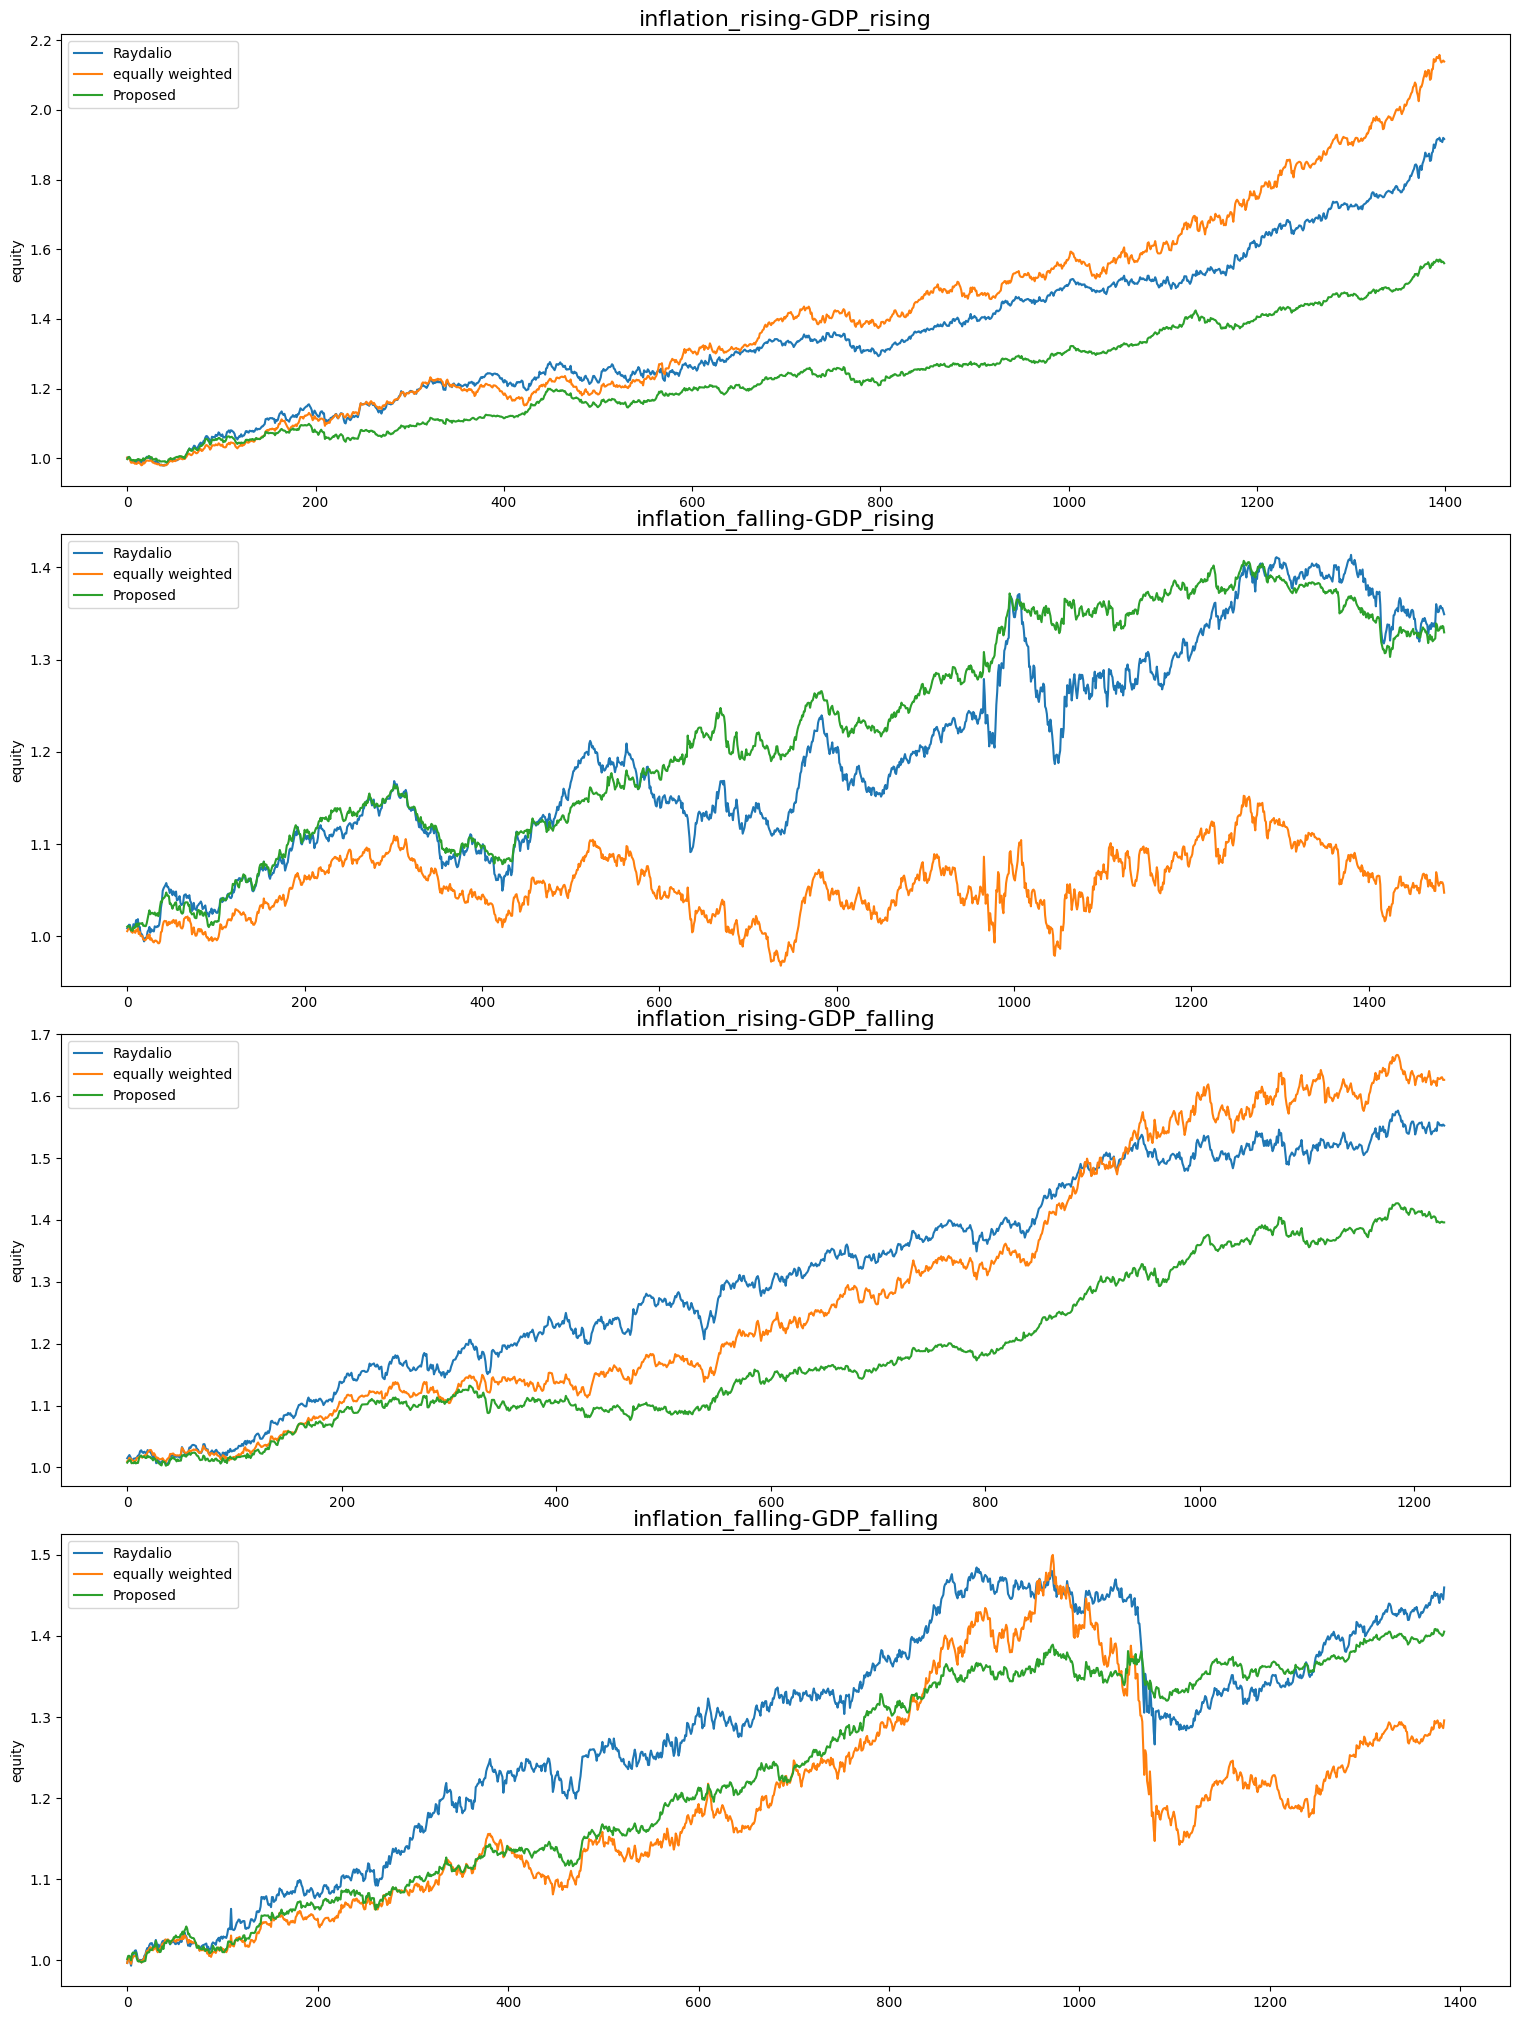

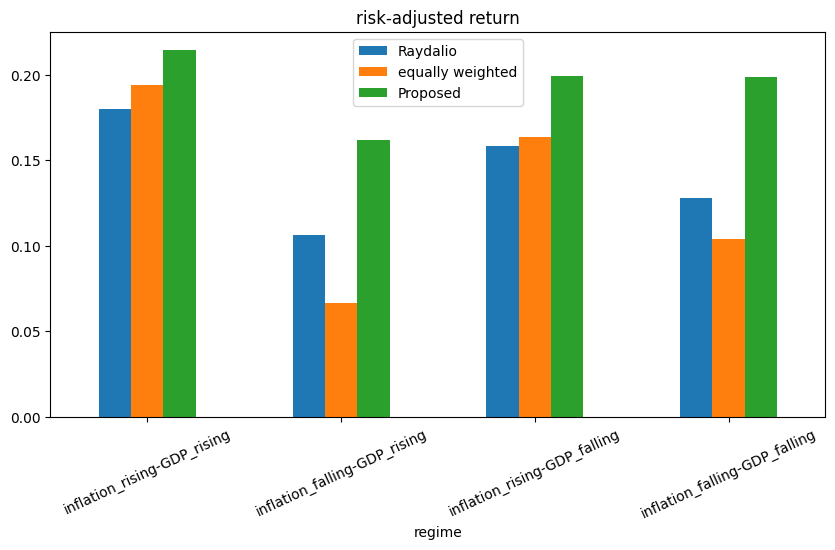

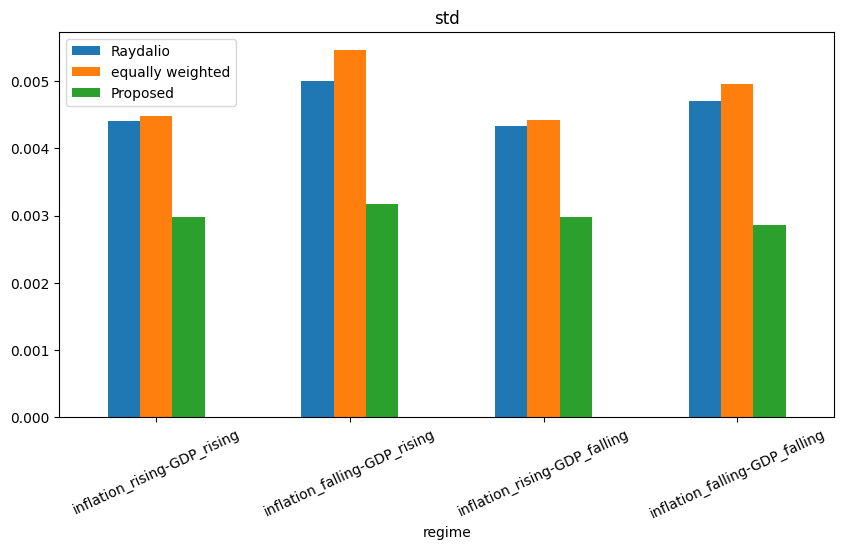

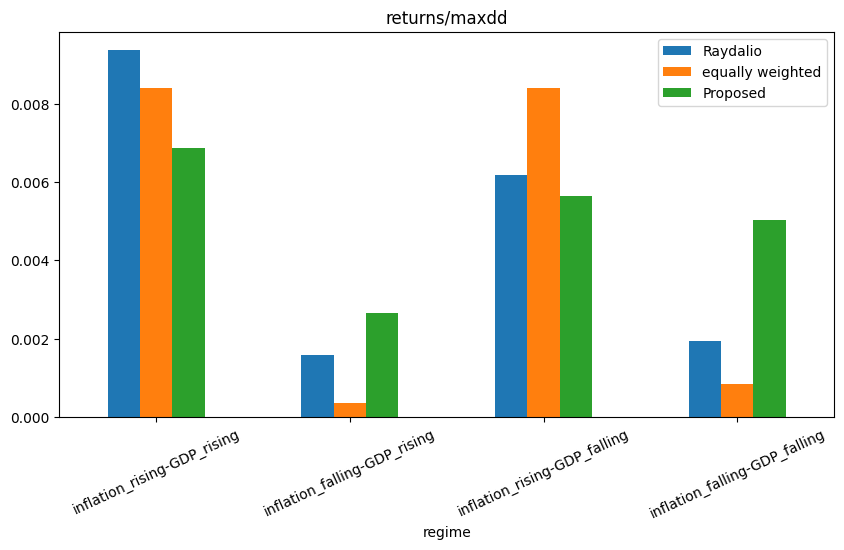

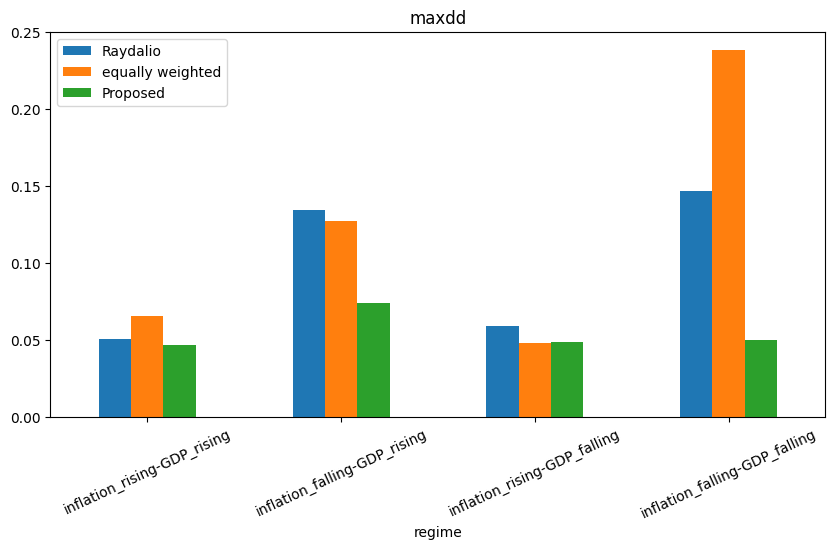

In [13]:
set1 = [[0.4,0.3,0.15,0.075,0.075], [1/5]*5, ALP.Optimize(ALP.Objective_metric).x]
labels = ['Raydalio', 'equally weighted','Proposed']
plot_errors(ALP,set1, labels)
ALP.plot_performance_byregime(set1, labels, mode=1, stats=True)

## Out of sample evaluation

all data points:
0.0    1353
1.0     974
Name: label, dtype: int64
all data points:
1.0    1199
0.0    1003
Name: label, dtype: int64
combinations:
[['data0_regime0', 'data1_regime0'], ['data0_regime1', 'data1_regime0'], ['data0_regime0', 'data1_regime1'], ['data0_regime1', 'data1_regime1']]
data points by combin:
data0_regime0-data1_regime0: 690
data0_regime1-data1_regime0: 313
data0_regime0-data1_regime1: 663
data0_regime1-data1_regime1: 536


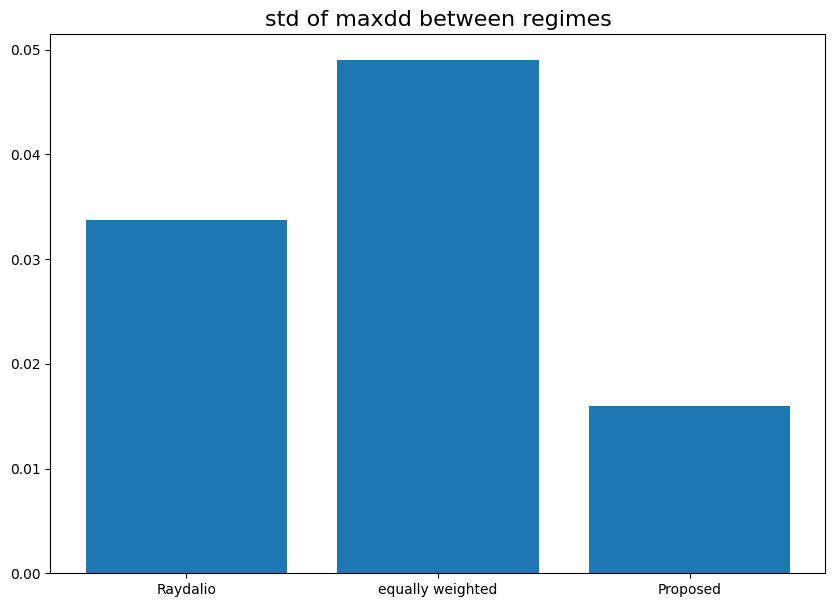

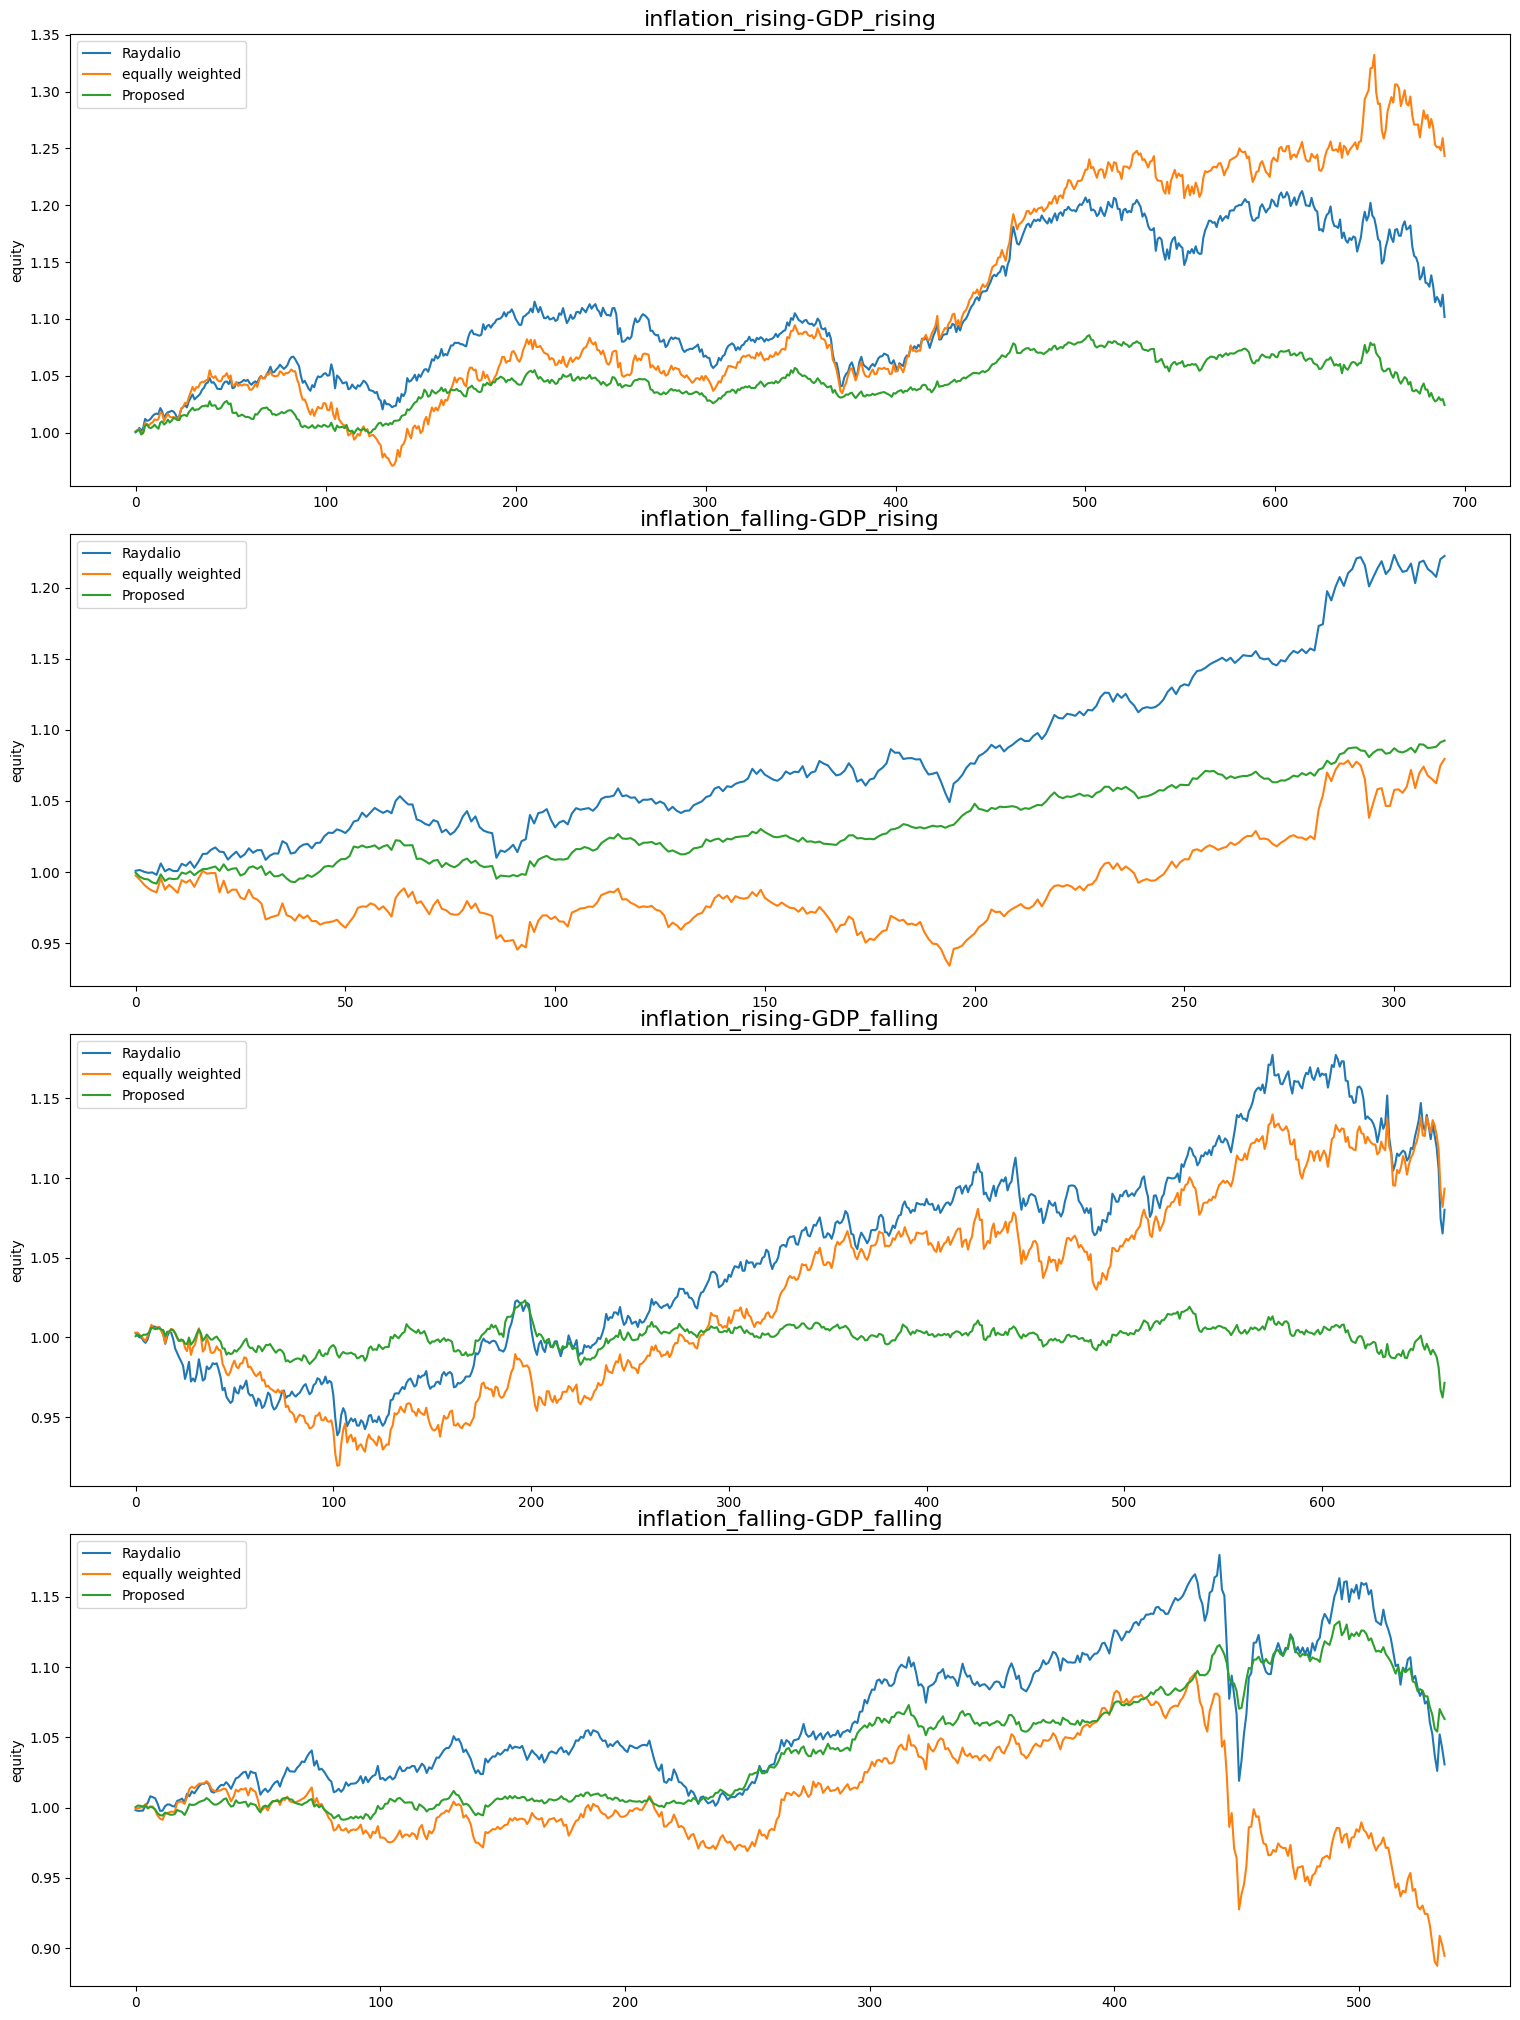

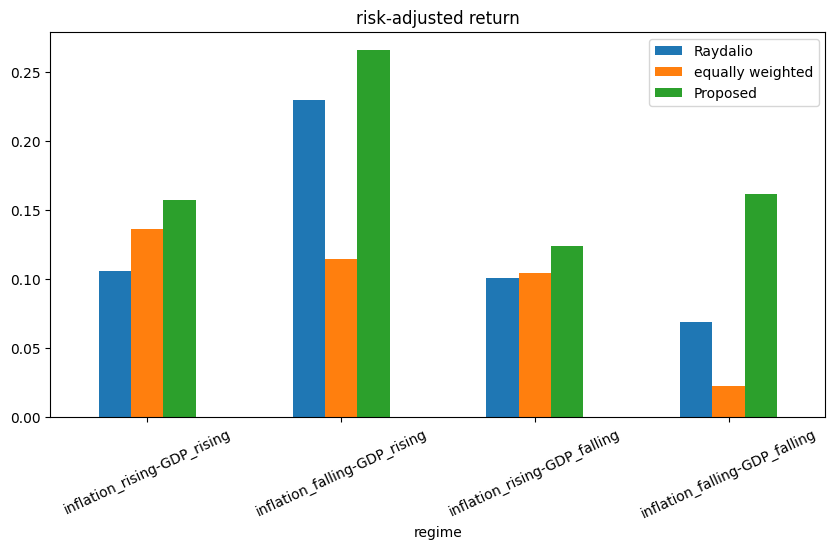

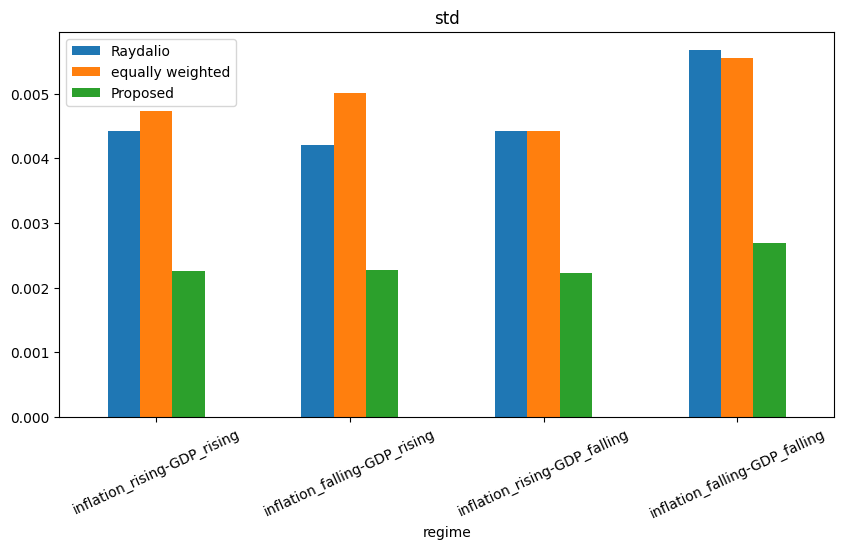

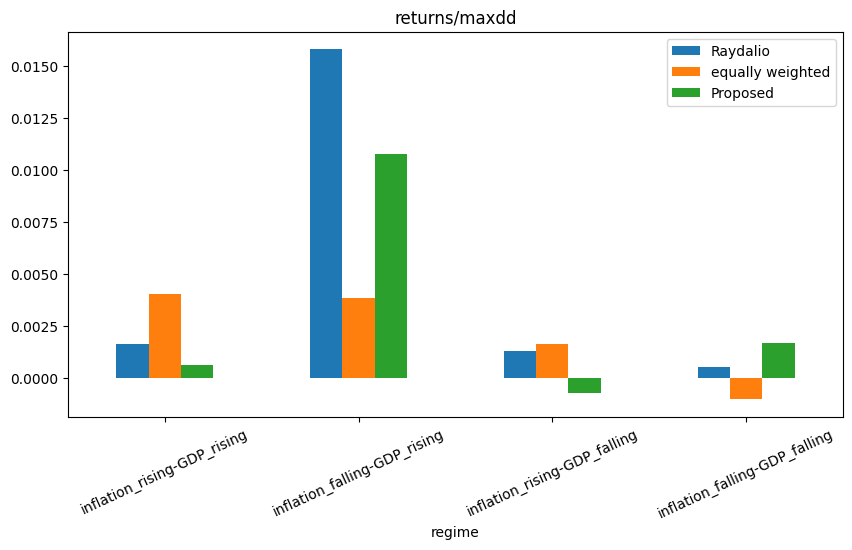

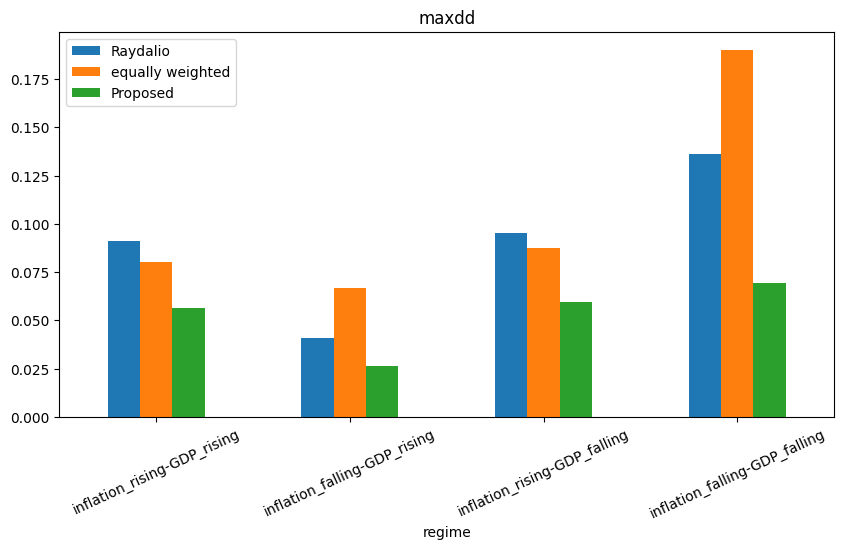

In [14]:
OOS1 = All_Weather_Portfolio(test_data, ['peak', 'peak'], [{'prominence':1},{}], inflation, pd.DataFrame(rate_of_change(gdp.GDP,120), index=gdp.index))
OOS1.regime_combinations()
plot_errors(OOS1, set1, labels)
OOS1.plot_performance_byregime(set1, labels , mode=1, stats=True)

## Correlation with regimes of the all weather portfolio

In [15]:
alp_weight = set1[2]
market_index = pd.read_csv('RUI.csv',index_col='Date', parse_dates=True)
rf = -0.000318
market_index = market_index.loc[unequal_compare(market_index.index, train_data.index)]
y = train_data.loc[unequal_compare(train_data.index, market_index.index)]
X = (market_index/market_index.shift(1)-1).dropna().to_numpy() - rf 
y = (y/y.shift(1)-1).dropna().to_numpy()@ alp_weight - rf 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
#market_index.to_csv('RUI.csv')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.42
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           6.34e-06
Time:                        11:47:58   Log-Likelihood:                 22929.
No. Observations:                5220   AIC:                        -4.585e+04
Df Residuals:                    5218   BIC:                        -4.584e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   4.15e-05     13.545      0.0

In [16]:
weight = set1[2]
rf = -0.000318
inflation_test = inflation.loc[unequal_compare(inflation.index, train_data.index)]
gdp_test = gdp.loc[unequal_compare(gdp.index, train_data.index)]
y = train_data.copy()
y = (y/y.shift(1)-1).dropna().to_numpy()@ weight - rf 
inflation_test = (inflation_test/inflation_test.shift(1)-1).dropna().to_numpy()
gdp_test = (gdp_test/gdp_test.shift(1)-1).dropna().to_numpy()
X = np.concatenate([inflation_test, gdp_test],axis=1)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8761
Date:                Wed, 26 Apr 2023   Prob (F-statistic):              0.416
Time:                        11:47:58   Log-Likelihood:                 24129.
No. Observations:                5499   AIC:                        -4.825e+04
Df Residuals:                    5496   BIC:                        -4.823e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   5.93e-05     10.662      0.0